In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\xiaowang\appdata\local\temp\pip-req-build-pfzhgf21
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\XiaoWang\AppData\Local\Temp\pip-req-build-pfzhgf21'


In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.12.1


## 加载模型

In [4]:
import clip
clip.available_models()
#这里展示可选择的不同图片特征提取器

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
#加载模型和图片处理器
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("模型参数:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("输入图片尺寸:", input_resolution)
print("文本长度:", context_length)
print("词表大小:", vocab_size)

模型参数: 151,277,313
输入图片尺寸: 224
文本长度: 77
词表大小: 49408


## 查看图片处理器

这里调整图片大小224*224，中心裁剪，然后使用均值和标准差进行归一化，最后输出tensor向量

In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000019AF08E71C0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## 文本分词

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## 输入图片和文本，并可视化

In [8]:
import os 
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format='retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

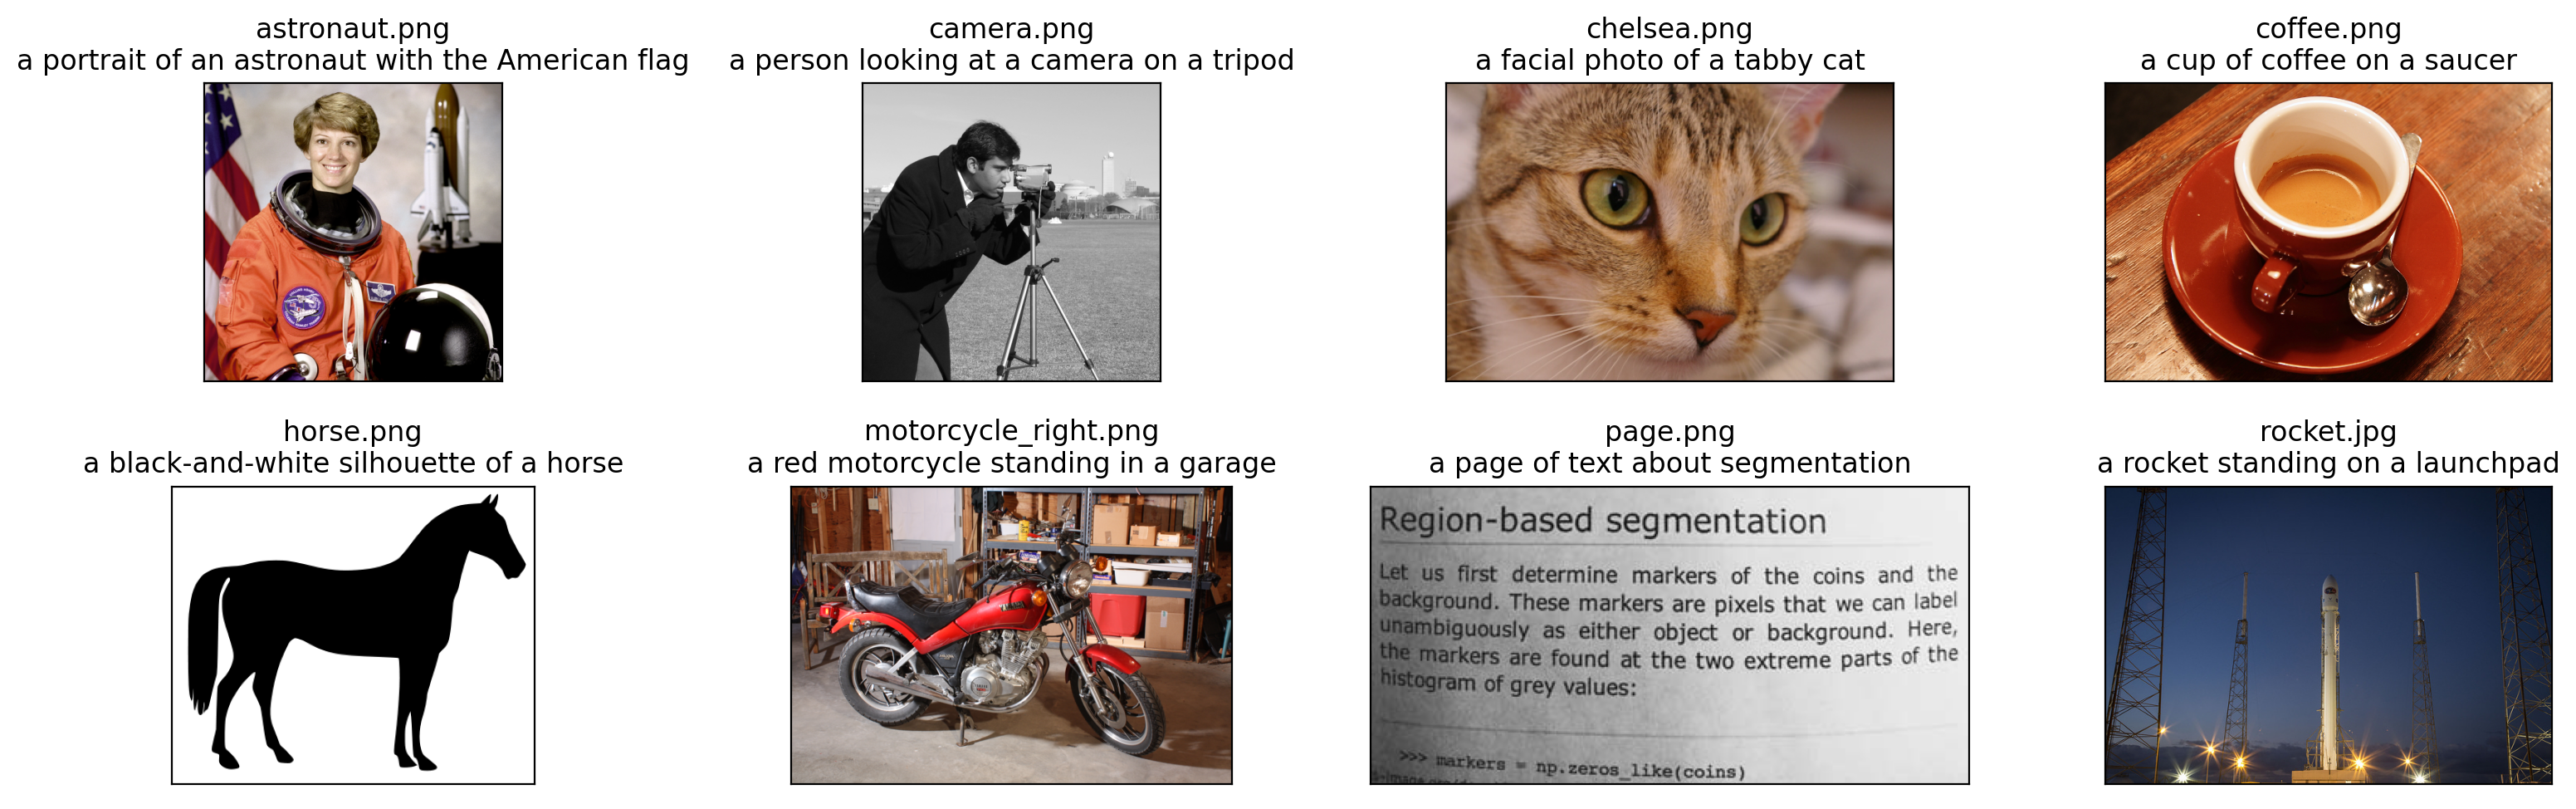

In [9]:
original_images=[]
images=[]
texts=[]
plt.figure(figsize=(16,5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

## 将图片和文字encode生成特征

In [10]:
image_input = torch.tensor(np.stack(images)).cuda()

print(image_input.shape)
text_tokens = clip.tokenize(['This is '+ desc for desc in texts]).cuda()

with torch.no_grad():
  image_features = model.encode_image(image_input).float()
  text_features = model.encode_text(text_tokens).float()
print(image_features.shape)
print(text_features.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 512])
torch.Size([8, 512])


## 计算cosine相似度

In [11]:
image_features /= image_features.norm(dim = -1,keepdim = True)
text_features /= text_features.norm(dim = -1,keepdim = True)

similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

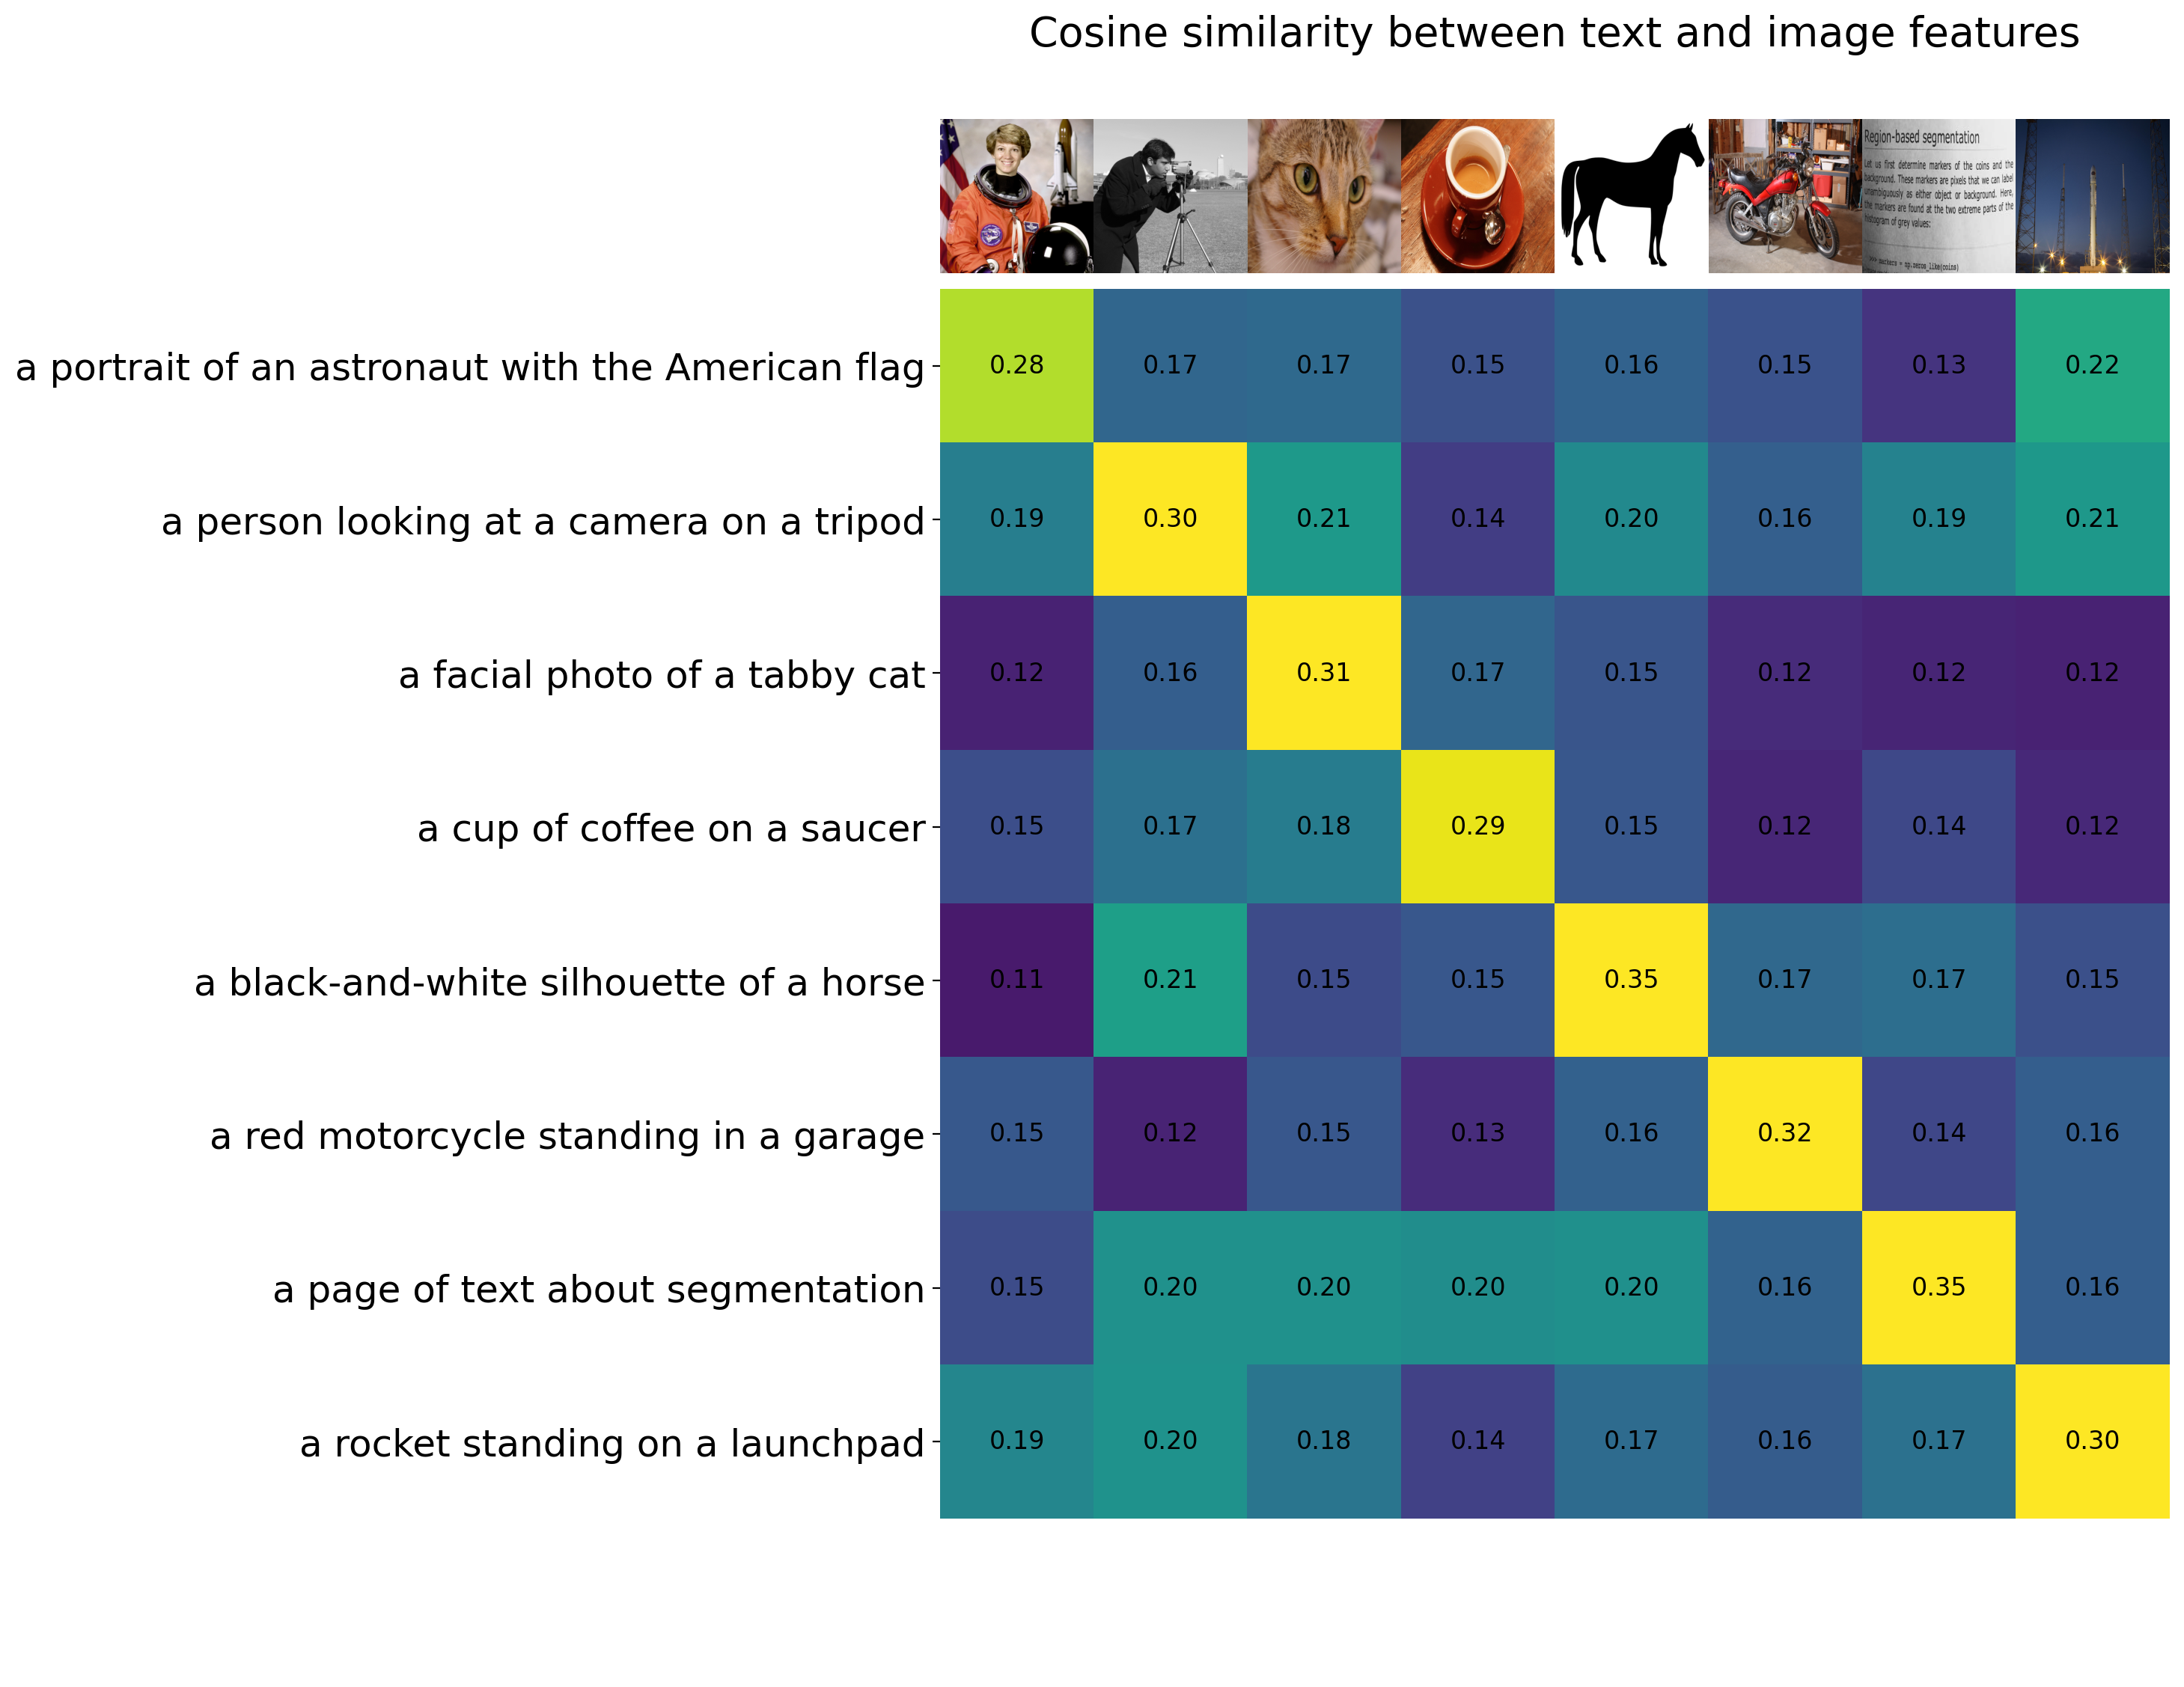

In [12]:
count = len(descriptions)
plt.figure(figsize = (20, 14))
plt.imshow(similarity, vmin = 0.1, vmax = 0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize = 18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent = (i - 0.5, i + 0.5, -1.6, -0.6), origin = "lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha = "center", va = "center", size = 12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size = 20)

## 零样本进行图片分类

数据集CIFAR100,就是使用相似度计算得分，然后softmax一下

In [14]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform = preprocess, download = True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting C:\Users\XiaoWang/.cache\cifar-100-python.tar.gz to C:\Users\XiaoWang/.cache


加上prompt提示模板进行分类

In [15]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

计算相似度得分

In [16]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim = -1, keepdim = True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim = -1)
top_probs, top_labels = text_probs.cpu().topk(5, dim = -1)

可视化结果

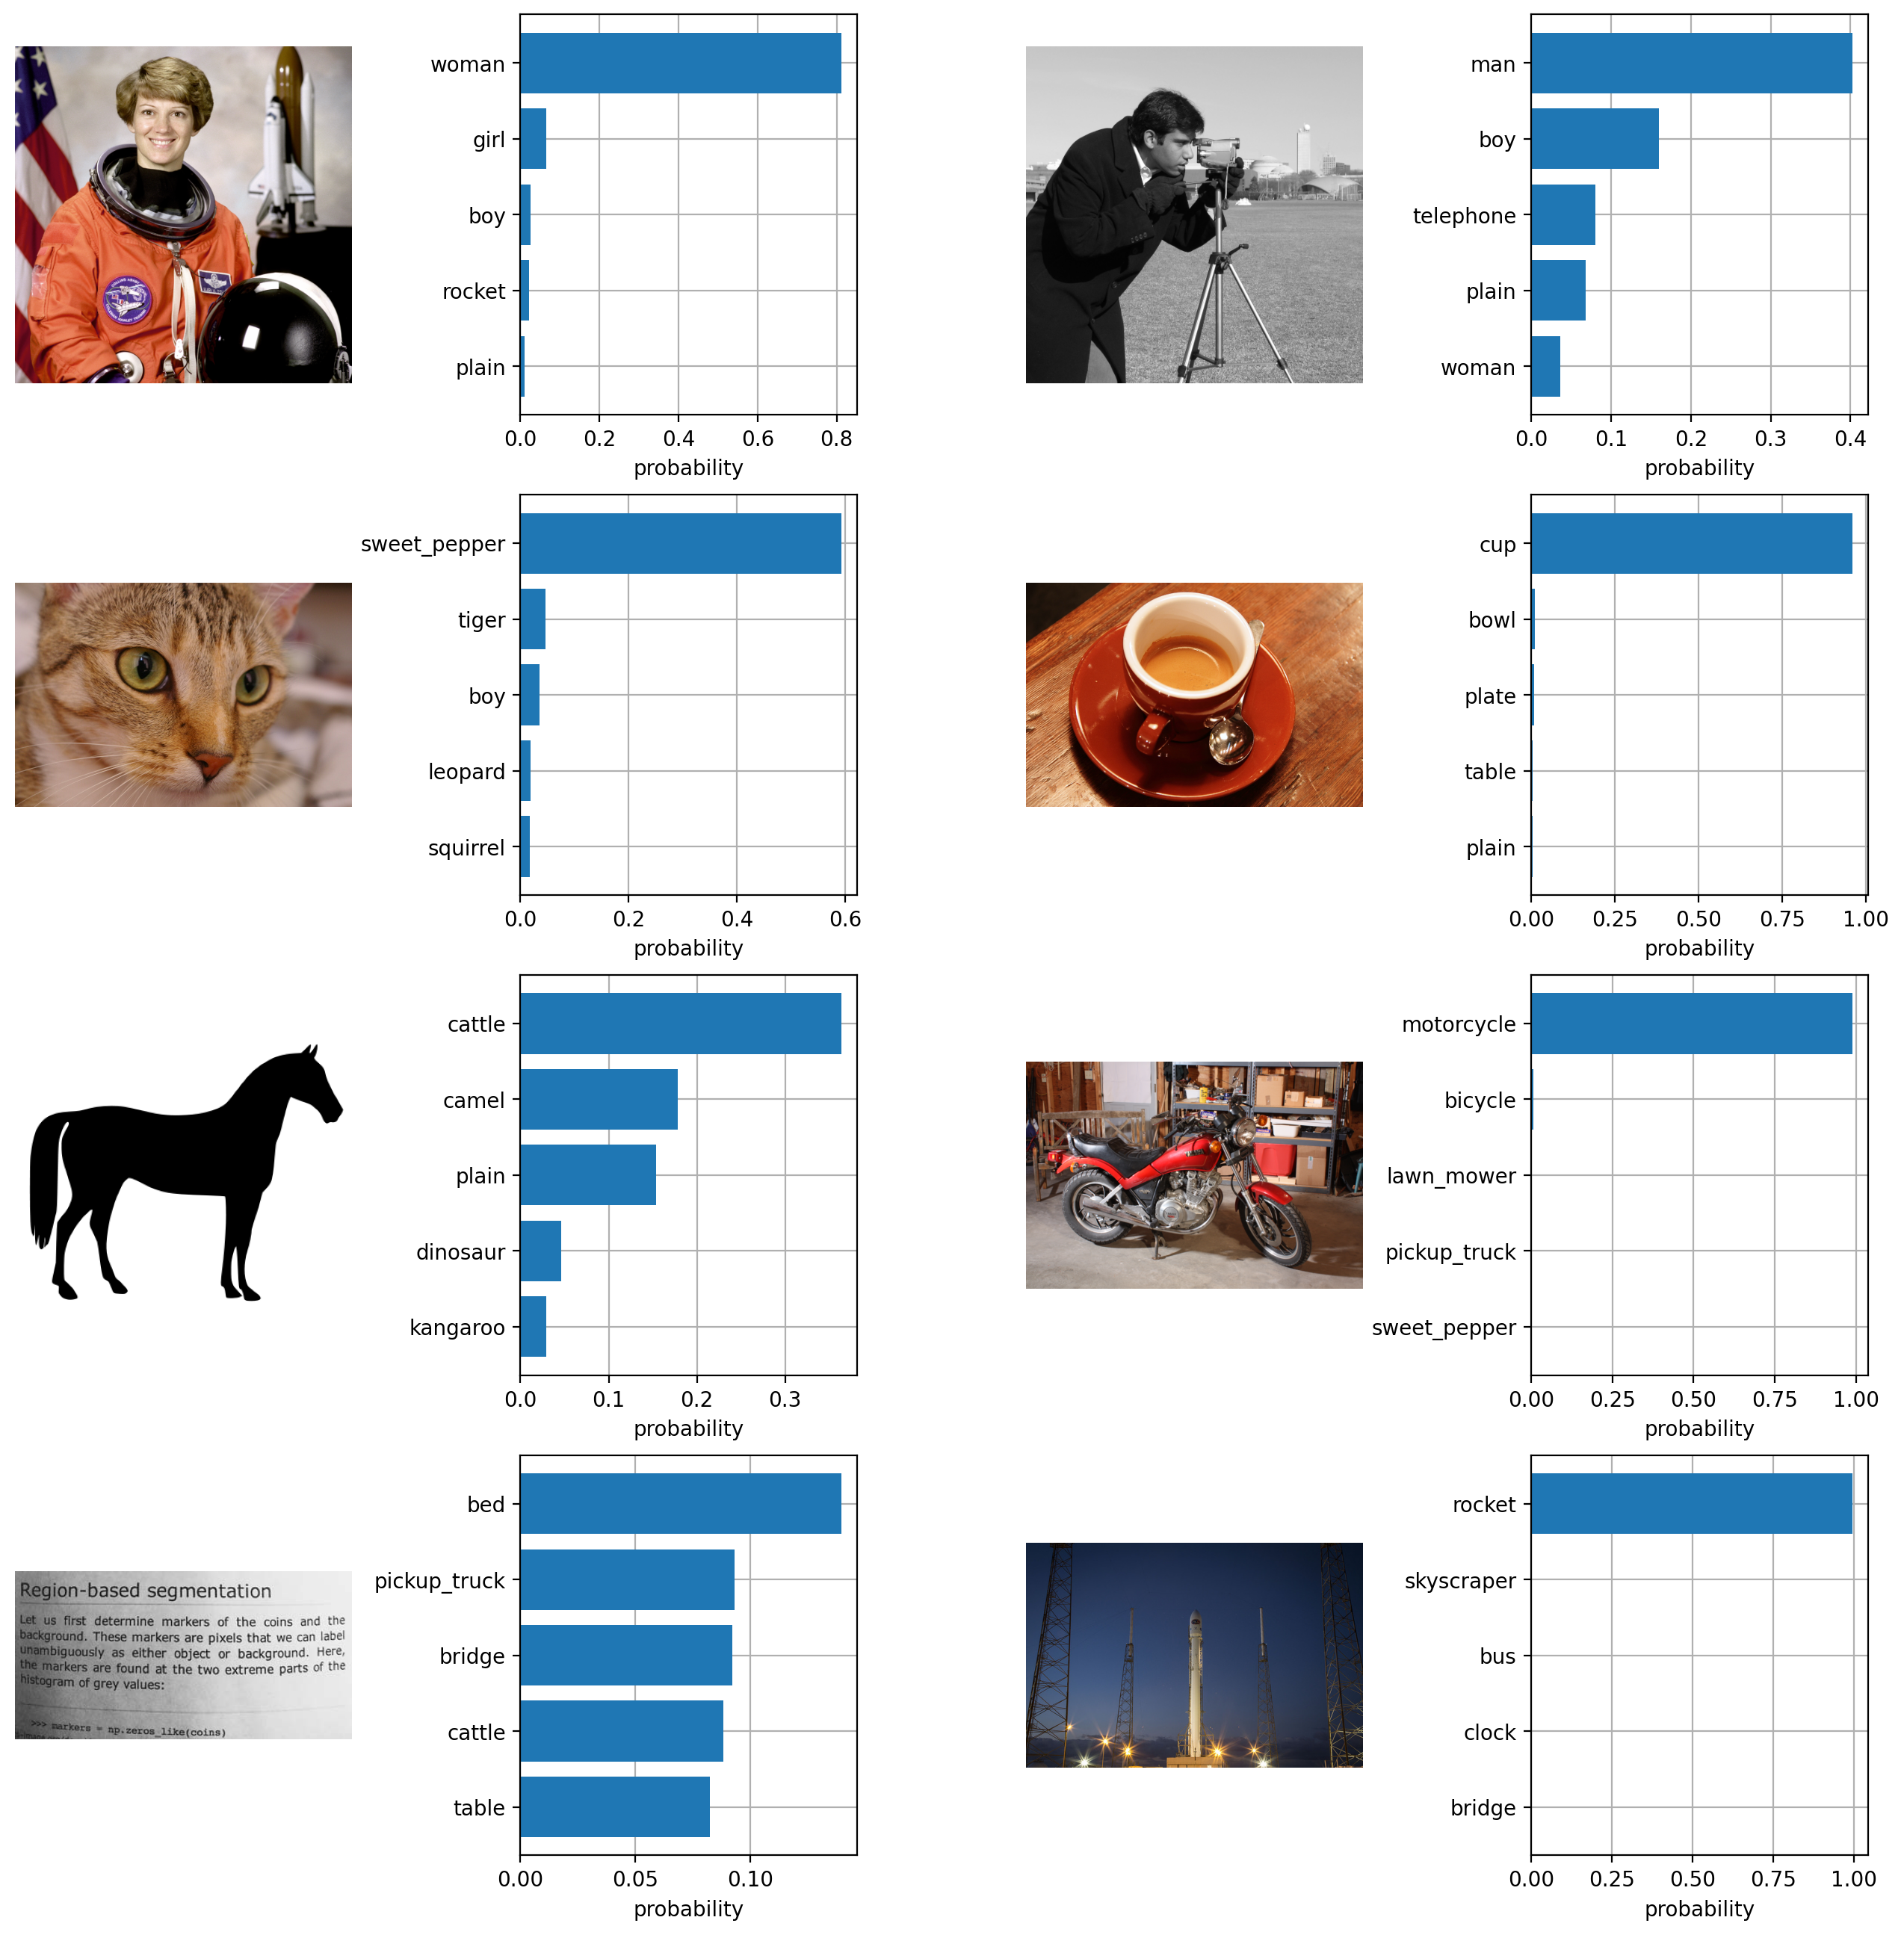

In [17]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace = 0.5)
plt.show()

## 编写函数进行图片分类

输入图片和供选择标签进行分类

In [18]:
def show_result(image, probs, labels, label_name):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.axis("off")

  plt.subplot(1, 2, 2)
  y = np.arange(probs.shape[-1])
  plt.grid()
  plt.barh(y, probs[0])
  plt.gca().invert_yaxis()
  plt.gca().set_axisbelow(True)
  plt.yticks(y, [label_name[index] for index in labels[0].numpy()])
  plt.xlabel("probability")

  plt.subplots_adjust(wspace = 0.5)
  plt.show()


def clip_classifier(image_path, choice_label, top_k = 5):
  # top_k小于choice_label数
  if top_k > len(choice_label):
    raise Exception('top_k大于候选标签数')

  # 读取图片
  image = Image.open(image_path).convert("RGB")
  # 输入特征
  text_descriptions = [f"This is a photo of a {label}" for label in choice_label]
  text_tokens = clip.tokenize(text_descriptions).cuda()
  image_input = preprocess(image)
  image_input = image_input.clone().detach().cuda()

  with torch.no_grad():
    image_features = model.encode_image(image_input.unsqueeze(0)).float()
    text_features = model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim = -1, keepdim = True)
    text_features /= text_features.norm(dim = -1, keepdim = True)

  #相似度得分
  text_probs = (100.0 * image_features @ text_features.T).softmax(dim = -1)
  top_probs, top_labels = text_probs.cpu().topk(5, dim = -1)
  show_result(image, top_probs, top_labels, choice_label)

测试自己的图像

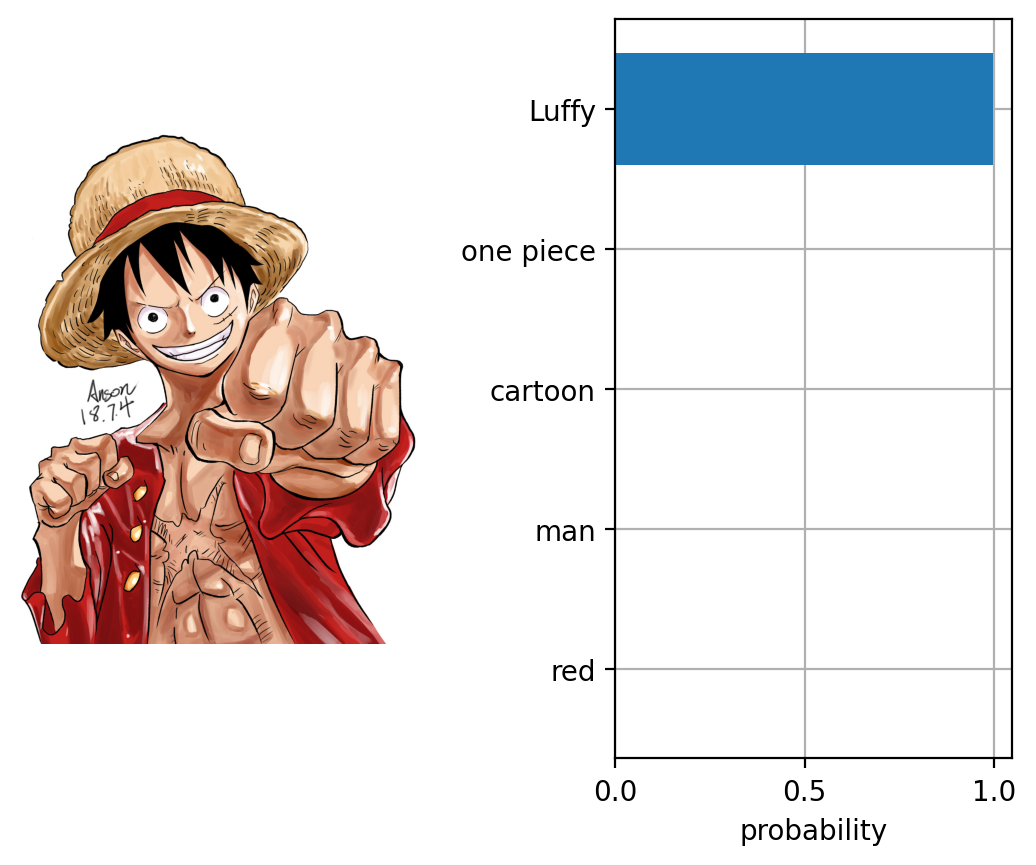

In [26]:
clip_classifier('R.jpg',['Luffy','pig','boy','girl','one piece','bleach','black','man','cartoon','red','detector'])

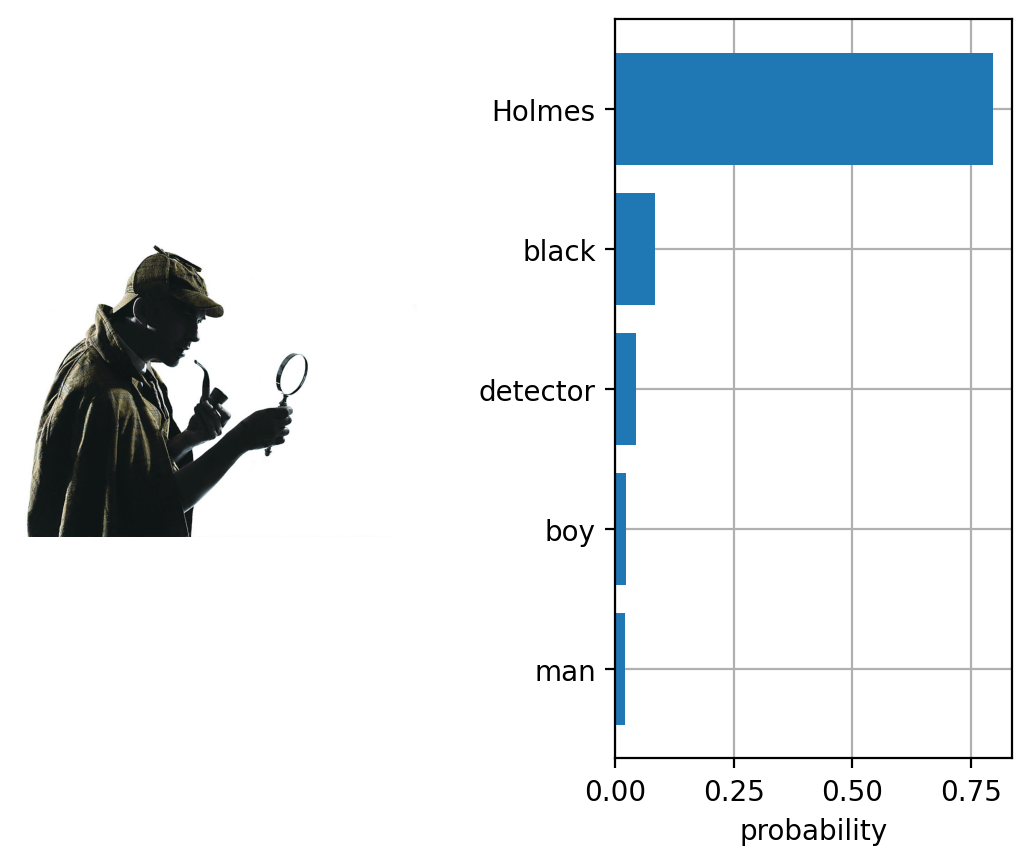

In [27]:
clip_classifier('Holmes.jpg',['Holmes','pig','boy','girl','one piece','bleach','black','man','cartoon','red','detector'])

## 对多图片进行分类

In [21]:
def clip_classifier_m(image_dir, choice_label, top_k = 5):
  # image_dir不为文件夹
  if not os.path.isdir(image_dir):
    raise Exception(image_dir + ' 应该为一个图片文件夹')

  # top_k小于choice_label数
  if top_k > len(choice_label):
    raise Exception('top_k大于候选标签数')


  #读取图片
  original_images = []
  images = []

  for filename in [filename for filename in os.listdir(image_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join(image_dir, filename)).convert("RGB")

    original_images.append(image)
    images.append(preprocess(image))

  # 输入特征
  text_descriptions = [f"This is a photo of a {label}" for label in choice_label]
  text_tokens = clip.tokenize(text_descriptions).cuda()
  image_input = torch.tensor(np.stack(images)).cuda()
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim = -1, keepdim = True)
    text_features /= text_features.norm(dim = -1, keepdim = True)

  # 相似度得分
  text_probs = (100.0 * image_features @ text_features.T).softmax(dim = -1)
  top_probs, top_labels = text_probs.cpu().topk(5, dim = -1)
  show_result_m(original_images, top_probs, top_labels, choice_label)


def show_result_m(images, probs, labels, label_name):
  length = len(images)
  num_row = length // 2

  plt.figure(figsize = (16, 16))

  for i, image in enumerate(images):
    plt.subplot(num_row, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(num_row, 4, 2 * i + 2)
    y = np.arange(probs.shape[-1])
    plt.grid()
    plt.barh(y, probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [label_name[index] for index in labels[i].numpy()])
    plt.xlabel("probability")

  plt.subplots_adjust(wspace = 1)
  plt.show()

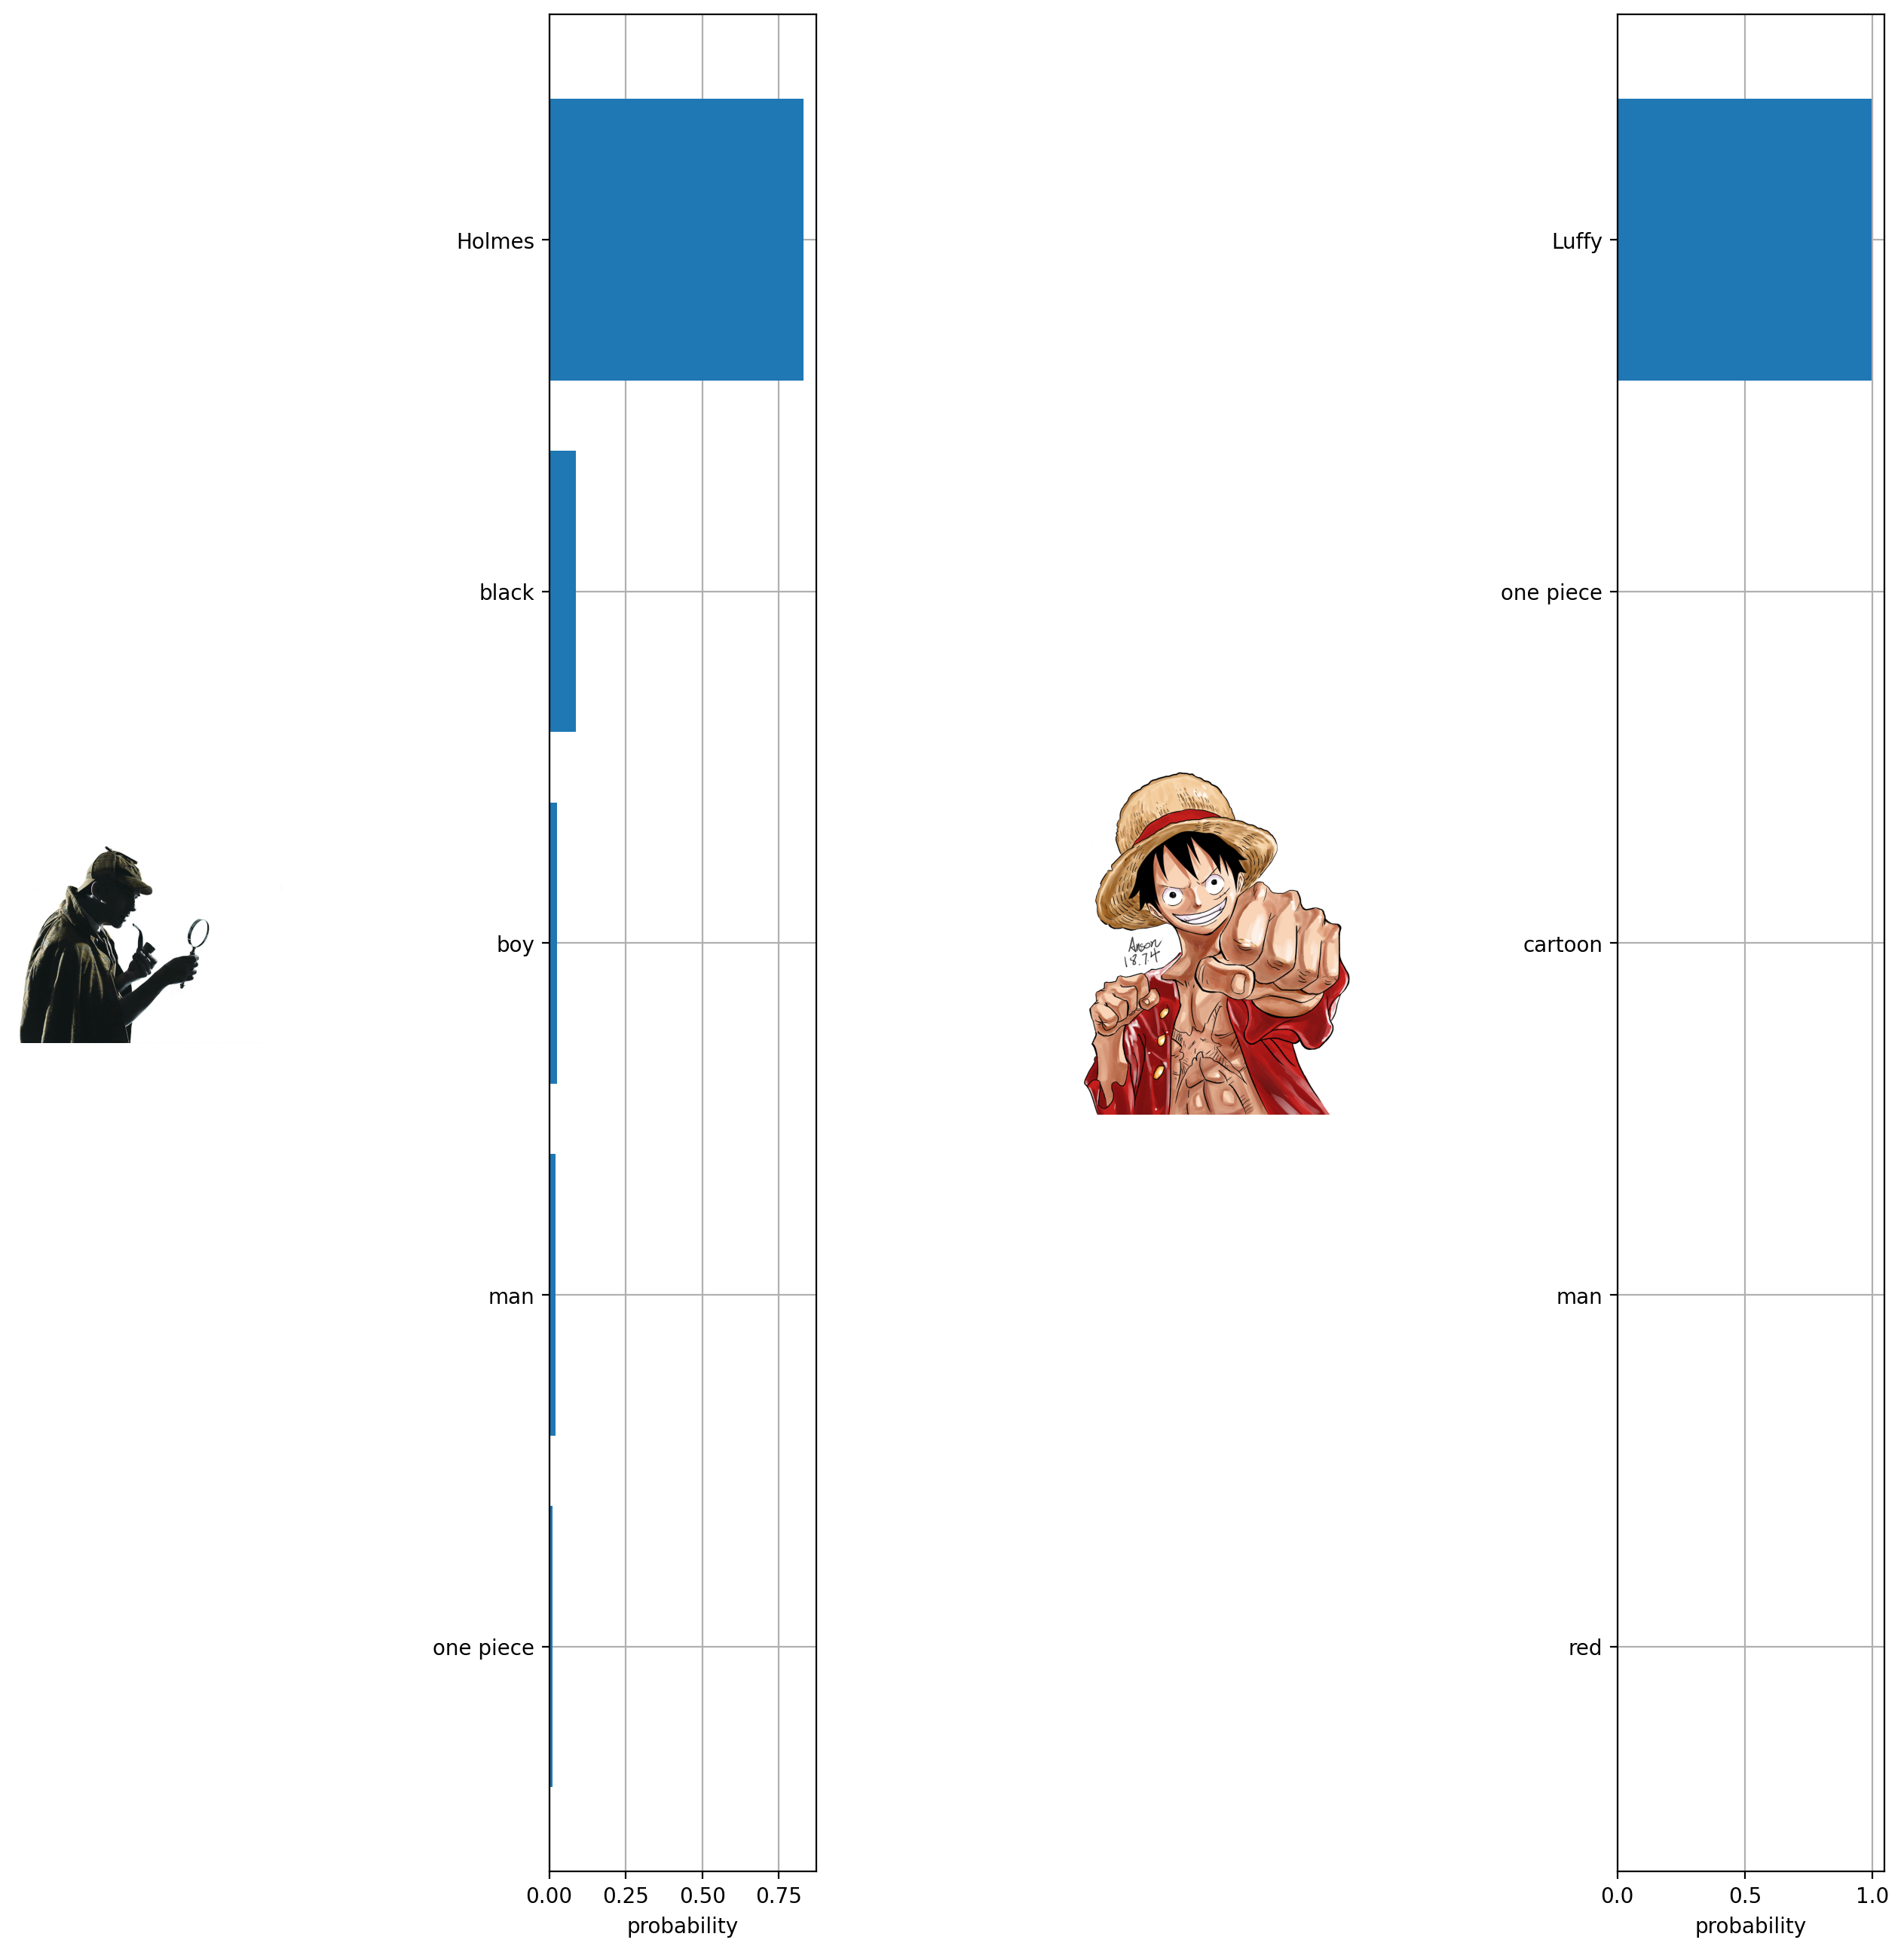

In [28]:
clip_classifier_m('img',['Luffy','pig','boy','girl','one piece','bleach','black','man','cartoon','red','Holmes'])